### Figure: Linking atmospheric forcing and ocean interior

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import scipy.stats as stats
import statsmodels.formula.api as sm

In [2]:
# Universal variables
rootdir = 'data/'
yrst = 1958
yrinit = 1976
yrend = 2016
years = np.arange(yrst,yrend+1,1)
years_c = 0.5*(years[:-1]+years[1:])
years_init = np.arange(yrinit,yrend+1,1)
years_init_c = 0.5*(years_init[:-1]+years_init[1:])

In [3]:
# Load NAO data
filepath_nao = rootdir+'raw/nao_station_djfm.txt'
nao_vals = np.loadtxt(filepath_nao,skiprows=1)[:,1]
nao_years = np.loadtxt(filepath_nao,skiprows=1)[:,0]+0.5
nao = xr.DataArray(nao_vals,dims=['years'],coords={'years':nao_years})
nao = nao.sel(years=slice(yrst,yrend))

# Load mixed layer volume from model
# This is the summed volume in the mixed layer north of 45N as defined by the somxl010 variable
# Evaluated in Feb-Mar-Apr of each year
# See calc_Vmld.py for details of calculation
filepath_mld = rootdir+'processed/eulerian/orca025_NA_Vmld.nc'
vmld = xr.open_dataarray(filepath_mld)

# Load volumetric distribution of age from ariane output
filepath_vlag = rootdir+'processed/lagrangian/D2_weights-init_volume_bins-final_age-init_t_subset-final_section-7_alt.nc'
vlag = xr.open_dataarray(filepath_vlag)

In [4]:
# PROCESS DATA

# Eulerian
# Group data by years and take the mean
vmld_byyear = vmld.groupby(vmld.time_counter.dt.year,years).mean(dim='time_counter')
# Calculate annual anomaly
vmld_anom = vmld_byyear-vmld_byyear.mean('year')

# Lagrangian

# Age anomaly
vlag_itmean = vlag.where(vlag!=0).mean('init_t_bin')
vlag_anom = (vlag.isel(init_t_bin=-1)-vlag_itmean)/vlag_itmean
# Rebrand coord as year
vlag_anom = vlag_anom.rename(
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years_c))

# Anomaly in volume of age 1
vlag_age1_mean = vlag.isel(final_age_bin=0).mean('init_t_bin')
vlag_age1_anom = vlag.isel(final_age_bin=0)-vlag_age1_mean
# Rebrand coord as year
vlag_age1_anom = vlag_age1_anom.rename(
    {'init_t_bin':'init_year_bin'}).assign_coords(
    init_year_bin=years_init_c)
# Anomaly in volume of age 2
vlag_age2_mean = vlag.isel(final_age_bin=1).mean('init_t_bin')
vlag_age2_anom = vlag.isel(final_age_bin=1)-vlag_age2_mean
# Rebrand coord as year
vlag_age2_anom = vlag_age2_anom.rename(
    {'init_t_bin':'init_year_bin'}).assign_coords(
    init_year_bin=years_init_c-1)

# %age re-entrainment after 1 year
vlag_inyear = vlag.isel(final_age_bin=0)
vlag_oneyearlater = vlag.shift(init_t_bin=-1).isel(final_age_bin=1)
vlag_twoyearlater = vlag.shift(init_t_bin=-2).isel(final_age_bin=2)
vlag_reent_oneyearlater = 100*(vlag_inyear-vlag_oneyearlater)/vlag_inyear
vlag_reent_twoyearlater = 100*(vlag_oneyearlater-vlag_twoyearlater)/vlag_inyear
vlag_reent_oneyearlater = vlag_reent_oneyearlater.rename(
    {'init_t_bin':'init_year_bin'}).assign_coords(
    init_year_bin=years_init_c)
vlag_reent_twoyearlater = vlag_reent_twoyearlater.rename(
    {'init_t_bin':'init_year_bin'}).assign_coords(
    init_year_bin=years_init_c)

In [5]:
# Subset variables for particular years and put them into a pandas dataframe
ys = slice(1976,2016)
ys_r = slice(2016,1976)
ags = slice(0,2016-1976)

years_vals = years_init_c
# Eulerian
nao_vals = nao.sel(years=ys).values
vmld_0_vals = vmld_anom.sel(year=ys).values
vmld_1_vals = np.concatenate((vmld_anom.sel(year=ys).values[1:],np.array([np.nan])))
# Lagrangian
vlag_itmean_vals = np.flip(vlag_itmean.sel(final_age_bin=ags)).values
vlag_anom_vals = np.flip(vlag_anom.sel(final_year_bin=ys_r)).values
vlag_age1_anom_vals = vlag_age1_anom.sel(init_year_bin=ys).values
vlag_age2_anom_vals = np.concatenate((vlag_age2_anom.sel(init_year_bin=ys).values,np.array([np.nan])))
df = pd.DataFrame({'years':years_vals,'nao':nao_vals,'vmld_0_anom':vmld_0_vals,'vmld_1_anom':vmld_1_vals,
                   'vlag_anom':vlag_anom_vals,'vlag_age1_anom':vlag_age1_anom_vals,'vlag_age2_anom':vlag_age2_anom_vals,
                   'vlag_itmean':vlag_itmean_vals})

Text(0, 0.5, 'Volume [$10^{15}\\,m^3$]')

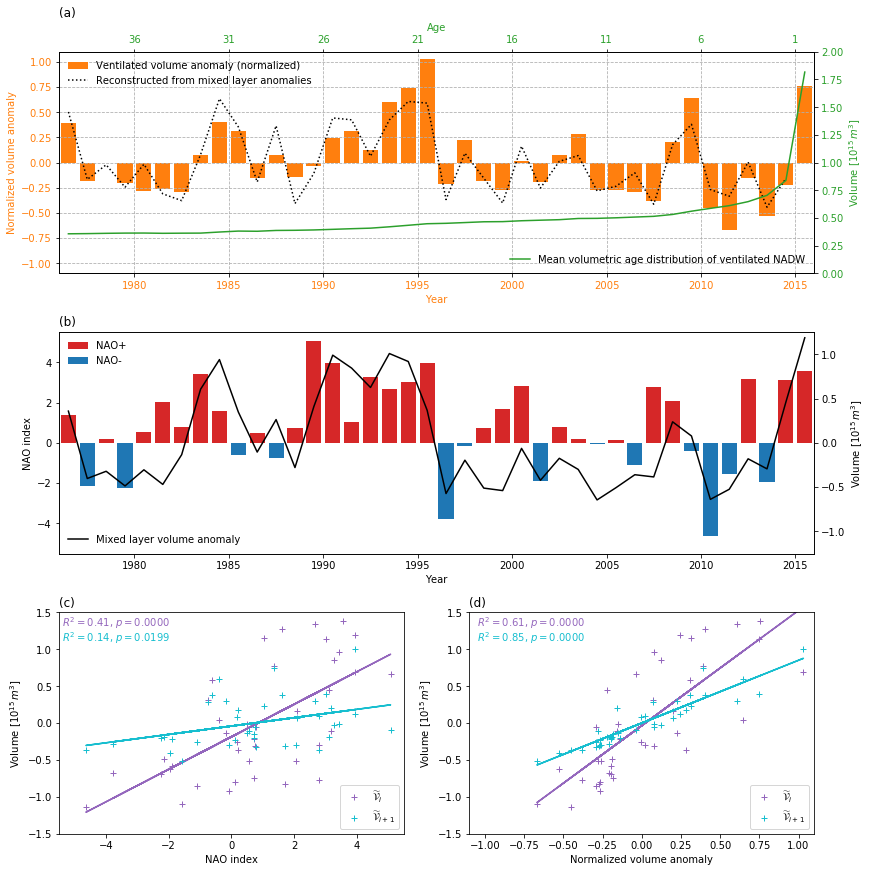

In [8]:
### FIGURE
xlims=[df['years'].min()-0.5, df['years'].max()+0.5]

fig = plt.figure(figsize=(12,12),constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax_lag = fig.add_subplot(gs[0, :])
ax_eul = fig.add_subplot(gs[1, :])
ax_regress1 = fig.add_subplot(gs[2, 0])
ax_regress2 = fig.add_subplot(gs[2, 1])

ax_lag.set_title('(a)',loc='left')
ax_eul.set_title('(b)',loc='left')
ax_regress1.set_title('(c)',loc='left')
ax_regress2.set_title('(d)',loc='left')

## PANEL: Mean age and annual anomaly
# PLOT: Annual anomaly
color = 'tab:orange'

ax_lag.bar(df['years'],df['vlag_anom'],color=color,label='Ventilated volume anomaly (normalized)')

# result = sm.ols(formula="vlag_anom ~ vmld_0_anom", data=df).fit()
# vlag_anom_recon1 = result.params.Intercept + df['vmld_0_anom']*result.params.vmld_0_anom
# ax_lag.plot(df['years'],vlag_anom_recon1,'k:',label='Reconstructed from mixed layer anomalies in same year')

result = sm.ols(formula="vlag_anom ~ vmld_0_anom + vmld_1_anom", data=df).fit()
vlag_anom_recon2 = result.params.Intercept + df['vmld_0_anom']*result.params.vmld_0_anom + df['vmld_1_anom']*result.params.vmld_1_anom
ax_lag.plot(df['years'],vlag_anom_recon2,'k:',label='Reconstructed from mixed layer anomalies')

ax_lag.set_xlim(xlims)
ax_lag.set_xlabel('Year',color=color)
ax_lag.set_ylim([-1.1,1.1])
ax_lag.set_ylabel('Normalized volume anomaly',color=color)
ax_lag.tick_params(axis='y', labelcolor=color)
ax_lag.tick_params(axis='x', labelcolor=color)

handles, labels = ax_lag.get_legend_handles_labels()
ax_lag.legend(reversed(handles), reversed(labels), loc='upper left',frameon=False)

ax_lag.grid(linestyle='--')

# PLOT: Mean age
color = 'tab:green'

ax_temp = ax_lag.twinx()
ax_temp.tick_params(axis='y', labelcolor=color)
ax_temp.set_ylabel('Volume [$10^{15}\,m^3$]',color=color)
ax1 = ax_temp.twiny()

ax1.plot(df['years'],1E-15*df['vlag_itmean'],'-',color=color,label='Mean volumetric age distribution of ventilated NADW')

ax1.set_ylim([0,2])
ax1.set_xlim(xlims)
xt = ax1.get_xticks()
ax1.set_xticklabels(2016-xt.astype(int))
ax1.set_xlabel('Age',color=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.legend(loc='lower right',frameon=False)

## PANEL: NAO and annual MLD anomaly
# PLOT: NAO
color_pos = 'tab:red'
nao_pos = df['nao'].where(df['nao']>0,0)
ax_eul.bar(df['years'],nao_pos,color=color_pos,label='NAO+')
color_neg = 'tab:blue'
nao_neg = df['nao'].where(df['nao']<0,0)
ax_eul.bar(df['years'],nao_neg,color=color_neg,label='NAO-')

ax_eul.set_xlim(xlims)
ax_eul.set_xlabel('Year')
ax_eul.set_ylim([-5.5,5.5])
ax_eul.set_ylabel('NAO index')
ax_eul.legend(loc='upper left',frameon=False)

# PLOT: MLD anomaly
ax1 = ax_eul.twinx()

ax1.plot(df['years'],1E-15*df['vmld_0_anom'],'k',label='Mixed layer volume anomaly')

ax1.set_ylim([-1.25,1.25])
ax1.set_ylabel('Volume [$10^{15}\,m^3$]')
ax1.legend(loc='lower left',frameon=False)

## PANEL: Regression (NAO)
xlims=[-5.5,5.5]
ylims = [-1.5,1.5]
color_age1 = 'tab:purple'
color_age2 = 'tab:cyan'

result = sm.ols(formula="vlag_age1_anom ~ nao", data=df).fit()
ax_regress1.plot(df['nao'],1E-15*df['vlag_age1_anom'],'+',color=color_age1,label='$\widetilde{\mathcal{V}}_i$')
ax_regress1.plot(df['nao'],1E-15*(result.params.Intercept+result.params.nao*df['nao']),'-',color=color_age1)
ax_regress1.text(xlims[0]+0.1,ylims[1]-0.2,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_age1)

result = sm.ols(formula="vlag_age2_anom ~ nao", data=df).fit()
ax_regress1.plot(df['nao'],1E-15*df['vlag_age2_anom'],'+',color=color_age2,label='$\widetilde{\mathcal{V}}_{i+1}$')
ax_regress1.plot(df['nao'],1E-15*(result.params.Intercept+result.params.nao*df['nao']),'-',color=color_age2)
ax_regress1.text(xlims[0]+0.1,ylims[1]-0.4,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_age2)

ax_regress1.legend(loc='lower right')
ax_regress1.set_xlim(xlims)
ax_regress1.set_xlabel('NAO index')
ax_regress1.set_ylim(ylims)
ax_regress1.set_ylabel('Volume [$10^{15}\,m^3$]')

## PANEL: Regression (anomaly)
xlims=[-1.1,1.1]

result = sm.ols(formula="vlag_age1_anom ~ vlag_anom", data=df).fit()
ax_regress2.plot(df['vlag_anom'],1E-15*df['vlag_age1_anom'],'+',color=color_age1,label='$\widetilde{\mathcal{V}}_i$')
ax_regress2.plot(df['vlag_anom'],1E-15*(result.params.Intercept+result.params.vlag_anom*df['vlag_anom']),'-',color=color_age1)
ax_regress2.text(xlims[0]+0.05,ylims[1]-0.2,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_age1)

result = sm.ols(formula="vlag_age2_anom ~ vlag_anom", data=df).fit()
ax_regress2.plot(df['vlag_anom'],1E-15*df['vlag_age2_anom'],'+',color=color_age2,label='$\widetilde{\mathcal{V}}_{i+1}$')
ax_regress2.plot(df['vlag_anom'],1E-15*(result.params.Intercept+result.params.vlag_anom*df['vlag_anom']),'-',color=color_age2)
ax_regress2.text(xlims[0]+0.05,ylims[1]-0.4,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_age2)

ax_regress2.legend(loc='lower right')
ax_regress2.set_xlim(xlims)
ax_regress2.set_xlabel('Normalized volume anomaly')
ax_regress2.set_ylim(ylims)
ax_regress2.set_ylabel('Volume [$10^{15}\,m^3$]')

### Integrals of reconstructed volume anomalies

In [288]:
truth = np.nansum((df['vlag_anom']*df['vlag_itmean']+df['vlag_itmean'])[:-1])
recon1 = np.nansum((vlag_anom_recon1*df['vlag_itmean']+df['vlag_itmean'])[:-1])
recon2 = np.nansum((vlag_anom_recon2*df['vlag_itmean']+df['vlag_itmean'])[:-1])

In [289]:
truth = np.nansum((df['vlag_anom'])[:-1])
recon1 = np.nansum((vlag_anom_recon1)[:-1])
recon2 = np.nansum((vlag_anom_recon2)[:-1])